# Libraries

In [1]:
import pyedflib
import plotly.express as px
from pathlib import Path
import os
import pandas as pd
import numpy as np
import EDF_wrapper
import filters
import re
from SwallowDetection.SwallowAnntations import get_swallow_annotations

In [2]:
directory = Path("data/edf/")
files = EDF_wrapper.read_files_from_dir(directory, load_files=True)
len(files)

6

In [3]:
def add_swallow_annotations(files: list, output_path:str="data/annotations/"):
    
    # Extract annotations from signal
    ann = []    
    for edf_file in np.asarray([file['filepath'] for file in files]):
        try:
            ann.append(get_swallow_annotations(edf_file))
        except:
            print(f"File {edf_file} failed to get swallow annotations.")
    
    for file, (times, annotations) in zip(files, ann):
        # Add extracted annotations to file's annotation list
        for time, annotation in zip(times, annotations):
            file['header']['annotations'].append([time, -1, annotation])
            
        file['header']['annotations'].sort(key=lambda x: x[0])
        # Save edited edf file
        EDF_wrapper.save_edf_file(file, output_path=output_path)

/Users/matheusnoschang/.pyenv/versions/3.9.6/envs/AFE/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/matheusnoschang/.pyenv/versions/3.9.6/envs/AFE/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/matheusnoschang/.pyenv/versions/3.9.6/envs/AFE/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator

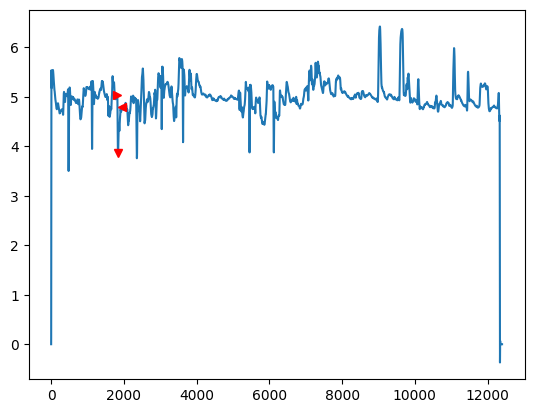

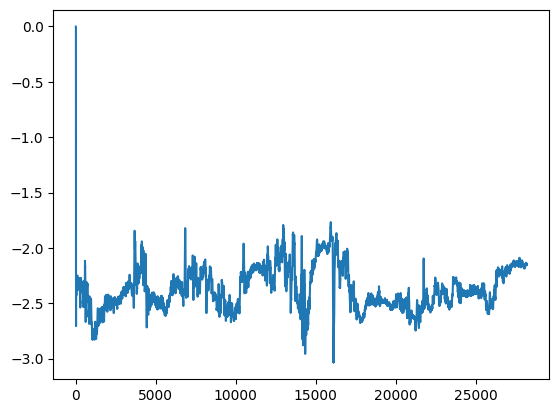

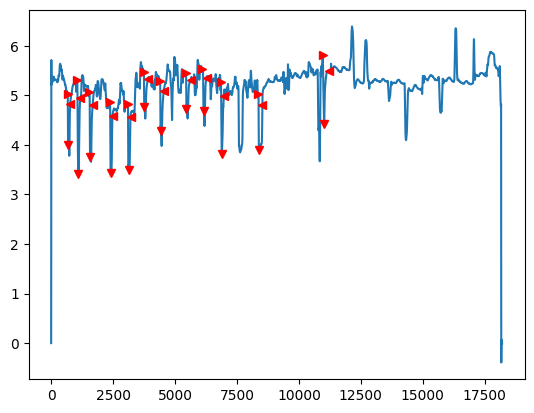

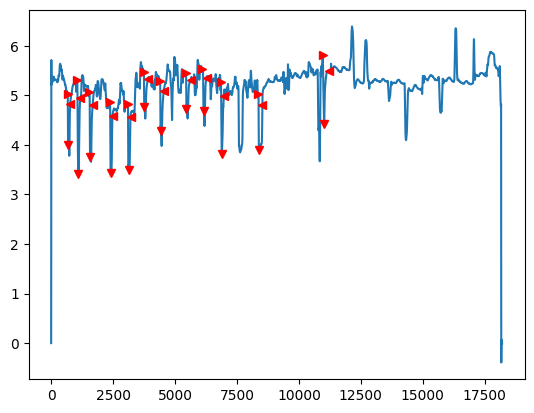

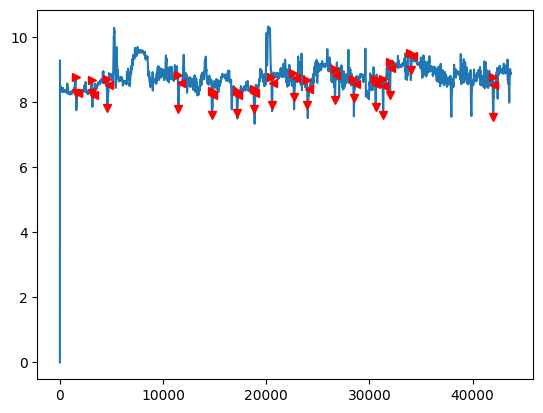

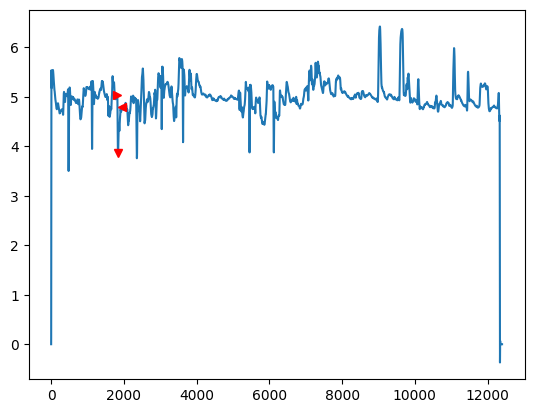

In [4]:
add_swallow_annotations(files)

In [5]:
directory = Path("data/annotations/")
annotated_files = EDF_wrapper.read_files_from_dir(directory, load_files=True)
annotated_files

[{'filepath': 'data/annotations/1-1-Bewegung_edited.bdf',
  'signals': array([[-2.65347050e+00, -4.09816558e+00, -4.09922416e+00, ...,
           1.10268599e-05,  1.10268599e-05,  1.10268599e-05],
         [-1.54233793e+00, -1.44602933e+00, -1.44344905e+00, ...,
           1.10268599e-05,  1.10268599e-05,  1.10268599e-05],
         [-3.29887115e+00,  4.98972898e+00,  4.99646807e+00, ...,
           5.65653954e-06,  5.65653954e-06,  5.65653954e-06],
         [-4.99413858e+00, -5.02268751e-02, -4.44226541e-02, ...,
           6.99207944e-06,  6.99207944e-06,  6.99207944e-06],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
  'signal_headers': [{'label': 'EMG 1',
    'dimension': 'mV',
    'sample_rate': 4000.0,
    'sample_frequency': 4000.0,
    'physical_max': 185.0,
    'physical_min': -185.0,
    'digital_max': 8388607,
    'digital_min': -8388608,
    'prefilter': '',
    'transducer': 'transkutan'},
 

In [ ]:
saved_file = pyedflib.highlevel.read_edf_header(f"data/annotations/{Path(files[3]['filepath']).name}")

In [ ]:
saved_file['annotations']

In [6]:
def compute_time(sampling_frequency, signal_array):
        # Calculate the time array based on the length of the signal array and the sampling frequency
        total_samples = len(signal_array)
        time_array = np.arange(total_samples) / sampling_frequency
        
        return time_array

In [69]:
def create_general_df(file, fileList=False):
    def find_first_element(list_data, condition):
        for element in list_data:
            if condition(element):
                return element
        return None
    
    def crop_signals_array(start_time, stop_time, file):
        cropped_signals = []
        for channel, signal in enumerate(file["signals"]):
            sr = file['signal_headers'][channel]['sample_rate']
            start_idx = round(start_time * sr)
            stop_idx = round(stop_time * sr) + 1
            time_array = compute_time(sr, signal)
            cropped_signals.append((time_array[start_idx: stop_idx], np.array(signal[start_idx: stop_idx])))
        return list(zip(file['signal_headers'], np.array(cropped_signals)))

    general = list(filter(lambda x : re.match("[pcts]_", x[-1]), file["header"]["annotations"]))

    rows = {"set": [], "subject": [], "category": [], "sample_name": [],
            "start_time": [], "stop_time": [],
             "header": [], "data_label": [], "time": [], "signal": []}

    for i, row in enumerate(general):
        time, _, desc = row
        s = desc.split("_")
        
        if s[0] == "c":
            if s[-1] == "start":
                _, cat, _ = s
            else:
                cat = '-'
            
        else:
            m, sample, event = s
            if m == 's':
                cat = 'swallow'
            else:
                cat = s[1]
                
            if event == "start":
                start_time = time
                stop_time, _, _ = find_first_element(general[i:], lambda x: x[-1] == f"{m}_{sample}_stop")
                if not fileList:
                    signals = crop_signals_array(start_time, stop_time, file)
                    if m == 's':
                        cat = 'swallow'
                    else: 
                        cat = sample
                        
                    for h, sigs in signals:
                        rows["set"].append(1)
                        rows["subject"].append(Path(file["filepath"]).stem)
                        rows["category"].append(cat)
                        rows["sample_name"].append(s[1])
                        rows["start_time"].append(start_time)
                        rows["stop_time"].append(stop_time)
                        rows["header"].append(h)
                        rows["data_label"].append(h['label'])
                        rows["time"].append(sigs[0])
                        rows["signal"].append(sigs[1])

    df = pd.DataFrame(rows)
    
    df = df.explode(['time', 'signal']).reset_index(drop=True)
    
    df["id"] = (df["subject"] + df["category"] + df["sample_name"]).astype("category")
    df["data_label"] = df["data_label"].astype("category")
    
    df["time"] = df["time"].astype(float)
    df["signal"] = df["signal"].astype(float)
    
    cat_columns = df.select_dtypes(['category']).columns

    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    
    # df['duration'] = df["stop_time"] - df["start_time"]
     
    return df

In [ ]:
file = files[3]

In [71]:
annotated_files[3]['header']['annotations']

[[2.8425, -1.0, 'schlucken normal'],
 [5.925, -1.0, 'c_category2_start'],
 [6.64, -1.0, 's_swallow_start'],
 [6.687, -1.0, 'p_elevation_start'],
 [6.687, -1.0, 'p_swallow_start'],
 [7.304, -1.0, 'p_elevation_stop'],
 [7.304, -1.0, 'p_lowering_start'],
 [7.539, -1.0, 'p_lowering_stop'],
 [7.539, -1.0, 'p_swallow_stop'],
 [7.74, -1.0, 's_swallow_stop'],
 [8.5357, -1.0, 'stop'],
 [10.53, -1.0, 's_swallow_start'],
 [11.0007, -1.0, 'schlucken normal'],
 [11.8, -1.0, 's_swallow_stop'],
 [15.45, -1.0, 's_swallow_start'],
 [15.463, -1.0, 'p_elevation_start'],
 [15.463, -1.0, 'p_swallow_start'],
 [16.079, -1.0, 'p_elevation_stop'],
 [16.079, -1.0, 'p_lowering_start'],
 [16.719, -1.0, 'p_lowering_stop'],
 [16.719, -1.0, 'p_swallow_stop'],
 [16.73, -1.0, 's_swallow_stop'],
 [18.3997, -1.0, 'stop'],
 [19.502, -1.0, 'c_category2_stop'],
 [20.3732, -1.0, 'schlucken hoch'],
 [23.76, -1.0, 's_swallow_start'],
 [24.77, -1.0, 's_swallow_stop'],
 [26.7485, -1.0, 'stop'],
 [28.8607, -1.0, 'schlucken hoch'

In [72]:
from annotations_validation import check_T_annotations, check_C_annotations

def check_annotations(file: dict) -> bool:
    match_pattern = r"[cspt]_\w+_(start|stop)"
    annotations = file["header"]["annotations"]
    
    if any(map(lambda x : not re.match(match_pattern, x[-1]), annotations)):
        pattern_mismatches = [i for i, val in enumerate(map(lambda x : re.match(match_pattern, x[-1]), annotations)) if val is None]
        print(f"There are {len(pattern_mismatches)} annotations out of the pattern.")
        #for idx in pattern_mismatches:
        #    print(idx, file["header"]["annotations"][idx])
    
    if not annotations:
        print("There are no annotations in the file.")
        return False
    
    elif check_C_annotations(list(filter(lambda x : re.match(r"c_\w+_\w+", x[-1]), annotations))):
        if check_T_annotations(list(filter(lambda x : re.match(r"[spt]_", x[-1]), annotations))):
            return True
    return False
    

In [73]:
ann_file = annotated_files[3]
ann_file

{'filepath': 'data/annotations/1-8-Bewegung_edited.bdf',
 'signals': array([[-8.24461777e+00, -1.04011408e+01, -1.04016701e+01, ...,
          1.10268599e-05,  1.10268599e-05,  1.10268599e-05],
        [-3.03411770e+00, -2.93099451e+00, -2.93311166e+00, ...,
          1.10268599e-05,  1.10268599e-05,  1.10268599e-05],
        [ 1.55562263e+00,  5.28697827e+00,  5.28641947e+00, ...,
          4.50865474e-06,  4.50865474e-06,  4.50865474e-06],
        [-4.60055487e+00, -3.27341003e+00, -3.26253536e+00, ...,
          1.09085608e-05,  1.09085608e-05,  1.09085608e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 'signal_headers': [{'label': 'EMG 1',
   'dimension': 'mV',
   'sample_rate': 4000.0,
   'sample_frequency': 4000.0,
   'physical_max': 185.0,
   'physical_min': -185.0,
   'digital_max': 8388607,
   'digital_min': -8388608,
   'prefilter': '',
   'transducer': 'transkutan'},
  {'label': 'EMG 3',
 

In [74]:
ann_file["header"]["annotations"] = list(map(lambda x: [x[0], x[1], x[2].lower()], ann_file["header"]["annotations"]))

In [75]:
ann_file["header"]["annotations"]

[[2.8425, -1.0, 'schlucken normal'],
 [5.925, -1.0, 'c_category2_start'],
 [6.64, -1.0, 's_swallow_start'],
 [6.687, -1.0, 'p_elevation_start'],
 [6.687, -1.0, 'p_swallow_start'],
 [7.304, -1.0, 'p_elevation_stop'],
 [7.304, -1.0, 'p_lowering_start'],
 [7.539, -1.0, 'p_lowering_stop'],
 [7.539, -1.0, 'p_swallow_stop'],
 [7.74, -1.0, 's_swallow_stop'],
 [8.5357, -1.0, 'stop'],
 [10.53, -1.0, 's_swallow_start'],
 [11.0007, -1.0, 'schlucken normal'],
 [11.8, -1.0, 's_swallow_stop'],
 [15.45, -1.0, 's_swallow_start'],
 [15.463, -1.0, 'p_elevation_start'],
 [15.463, -1.0, 'p_swallow_start'],
 [16.079, -1.0, 'p_elevation_stop'],
 [16.079, -1.0, 'p_lowering_start'],
 [16.719, -1.0, 'p_lowering_stop'],
 [16.719, -1.0, 'p_swallow_stop'],
 [16.73, -1.0, 's_swallow_stop'],
 [18.3997, -1.0, 'stop'],
 [19.502, -1.0, 'c_category2_stop'],
 [20.3732, -1.0, 'schlucken hoch'],
 [23.76, -1.0, 's_swallow_start'],
 [24.77, -1.0, 's_swallow_stop'],
 [26.7485, -1.0, 'stop'],
 [28.8607, -1.0, 'schlucken hoch'

In [76]:
ann_file["header"]["annotations"].append([15.20, -1, 't_swall_start'])

In [78]:
ann_file["header"]["annotations"].pop()

[15.2, -1, 't_swall_start']

In [79]:
check_annotations(ann_file)

There are 62 annotations out of the pattern.


True

In [70]:
general_df = create_general_df(ann_file)
general_df
# final = general_df.loc[general_df['data_label'] == 2, ['id', 'time', 'signal']]
# final

,set,subject,category,sample_name,start_time,stop_time,header,data_label,time,signal,id
0,1,1-8-Bewegung_edited,swallow,swallow,6.640,7.740,"{'label': 'EMG 1', 'dimension': 'mV', 'sample_...",2,6.64000,-10.277022,3
1,1,1-8-Bewegung_edited,swallow,swallow,6.640,7.740,"{'label': 'EMG 1', 'dimension': 'mV', 'sample_...",2,6.64025,-10.264297,3
2,1,1-8-Bewegung_edited,swallow,swallow,6.640,7.740,"{'label': 'EMG 1', 'dimension': 'mV', 'sample_...",2,6.64050,-10.251572,3
3,1,1-8-Bewegung_edited,swallow,swallow,6.640,7.740,"{'label': 'EMG 1', 'dimension': 'mV', 'sample_...",2,6.64075,-10.251572,3
4,1,1-8-Bewegung_edited,swallow,swallow,6.640,7.740,"{'label': 'EMG 1', 'dimension': 'mV', 'sample_...",2,6.64100,-10.251021,3
...,...,...,...,...,...,...,...,...,...,...,...
534340,1,1-8-Bewegung_edited,movement,movement,162.616,163.881,"{'label': 'sync', 'dimension': 'no', 'sample_r...",4,163.88000,0.000000,2
534341,1,1-8-Bewegung_edited,movement,movement,162.616,163.881,"{'label': 'sync', 'dimension': 'no', 'sample_r...",4,163.88025,0.000000,2
534342,1,1-8-Bewegung_edited,movement,movement,162.616,163.881,"{'label': 'sync', 'dimension': 'no', 'sample_r...",4,163.88050,0.000000,2
534343,1,1-8-Bewegung_edited,movement,movement,162.616,163.881,"{'label': 'sync', 'dimension': 'no', 'sample_r...",4,163.88075,0.000000,2


In [68]:
general_df[general_df.category != 'swallow']

,set,subject,category,sample_name,start_time,stop_time,header,data_label,time,signal,id
22005,1,1-8-Bewegung_edited,elevation,elevation,6.687,7.304,"{'label': 'EMG 1', 'dimension': 'mV', 'sample_...",2,6.68700,-10.326908,0
22006,1,1-8-Bewegung_edited,elevation,elevation,6.687,7.304,"{'label': 'EMG 1', 'dimension': 'mV', 'sample_...",2,6.68725,-10.325298,0
22007,1,1-8-Bewegung_edited,elevation,elevation,6.687,7.304,"{'label': 'EMG 1', 'dimension': 'mV', 'sample_...",2,6.68750,-10.335906,0
22008,1,1-8-Bewegung_edited,elevation,elevation,6.687,7.304,"{'label': 'EMG 1', 'dimension': 'mV', 'sample_...",2,6.68775,-10.338045,0
22009,1,1-8-Bewegung_edited,elevation,elevation,6.687,7.304,"{'label': 'EMG 1', 'dimension': 'mV', 'sample_...",2,6.68800,-10.349182,0
...,...,...,...,...,...,...,...,...,...,...,...
534340,1,1-8-Bewegung_edited,movement,movement,162.616,163.881,"{'label': 'sync', 'dimension': 'no', 'sample_r...",4,163.88000,0.000000,2
534341,1,1-8-Bewegung_edited,movement,movement,162.616,163.881,"{'label': 'sync', 'dimension': 'no', 'sample_r...",4,163.88025,0.000000,2
534342,1,1-8-Bewegung_edited,movement,movement,162.616,163.881,"{'label': 'sync', 'dimension': 'no', 'sample_r...",4,163.88050,0.000000,2
534343,1,1-8-Bewegung_edited,movement,movement,162.616,163.881,"{'label': 'sync', 'dimension': 'no', 'sample_r...",4,163.88075,0.000000,2


## TSFresh tests

In [ ]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters

In [ ]:
final.dtypes

In [ ]:
# Define your extraction settings (optional)
extraction_settings = MinimalFCParameters()

# # Remove the 'sample_entropy' calculation from the extraction settings
# extraction_settings.pop('sample_entropy', None)

# Perform feature extraction without the 'sample_entropy' calculation
X = extract_features(final.head(15000), column_id='id', column_sort='time',
                     #column_kind='data_label', column_value='signal',
                     default_fc_parameters=extraction_settings,
                     impute_function=impute
                     )

In [ ]:
X.to_excel('data/xlsx/bewegungs_edited-data-label-2_minimal.xlsx')